In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv('SolarPrediction.csv')
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [3]:


# Rename 'Data' column to 'DateTime' for clarity
df = df.rename(columns={'Data': 'DateTime'})

# Convert DateTime to pandas datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Convert Time column to datetime.time objects for better handling
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Similarly, convert sunrise and sunset times
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'], format='%H:%M:%S').dt.time
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'], format='%H:%M:%S').dt.time

# Sort by DateTime to ensure proper plotting
df = df.sort_values('DateTime')
df

,UNIXTime,DateTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7223,1472793006,2016-09-01,19:10:06,2.53,55,30.45,65,155.71,3.37,06:07:00,18:38:00
7257,1472781308,2016-09-01,15:55:08,628.80,63,30.42,58,1.55,6.75,06:07:00,18:38:00
7256,1472781606,2016-09-01,16:00:06,596.57,62,30.42,56,81.70,5.62,06:07:00,18:38:00
7255,1472781907,2016-09-01,16:05:07,577.10,62,30.42,57,53.61,7.87,06:07:00,18:38:00
7254,1472782211,2016-09-01,16:10:11,573.13,62,30.42,58,14.04,3.37,06:07:00,18:38:00
...,...,...,...,...,...,...,...,...,...,...,...
24714,1483206901,2016-12-31,07:55:01,39.30,43,30.31,86,262.51,5.62,06:57:00,17:54:00
24715,1483206602,2016-12-31,07:50:02,39.51,42,30.31,85,265.53,7.87,06:57:00,17:54:00
24716,1483206302,2016-12-31,07:45:02,52.87,42,30.31,84,240.48,4.50,06:57:00,17:54:00
24664,1483221902,2016-12-31,12:05:02,378.41,53,30.33,68,321.95,10.12,06:57:00,17:54:00


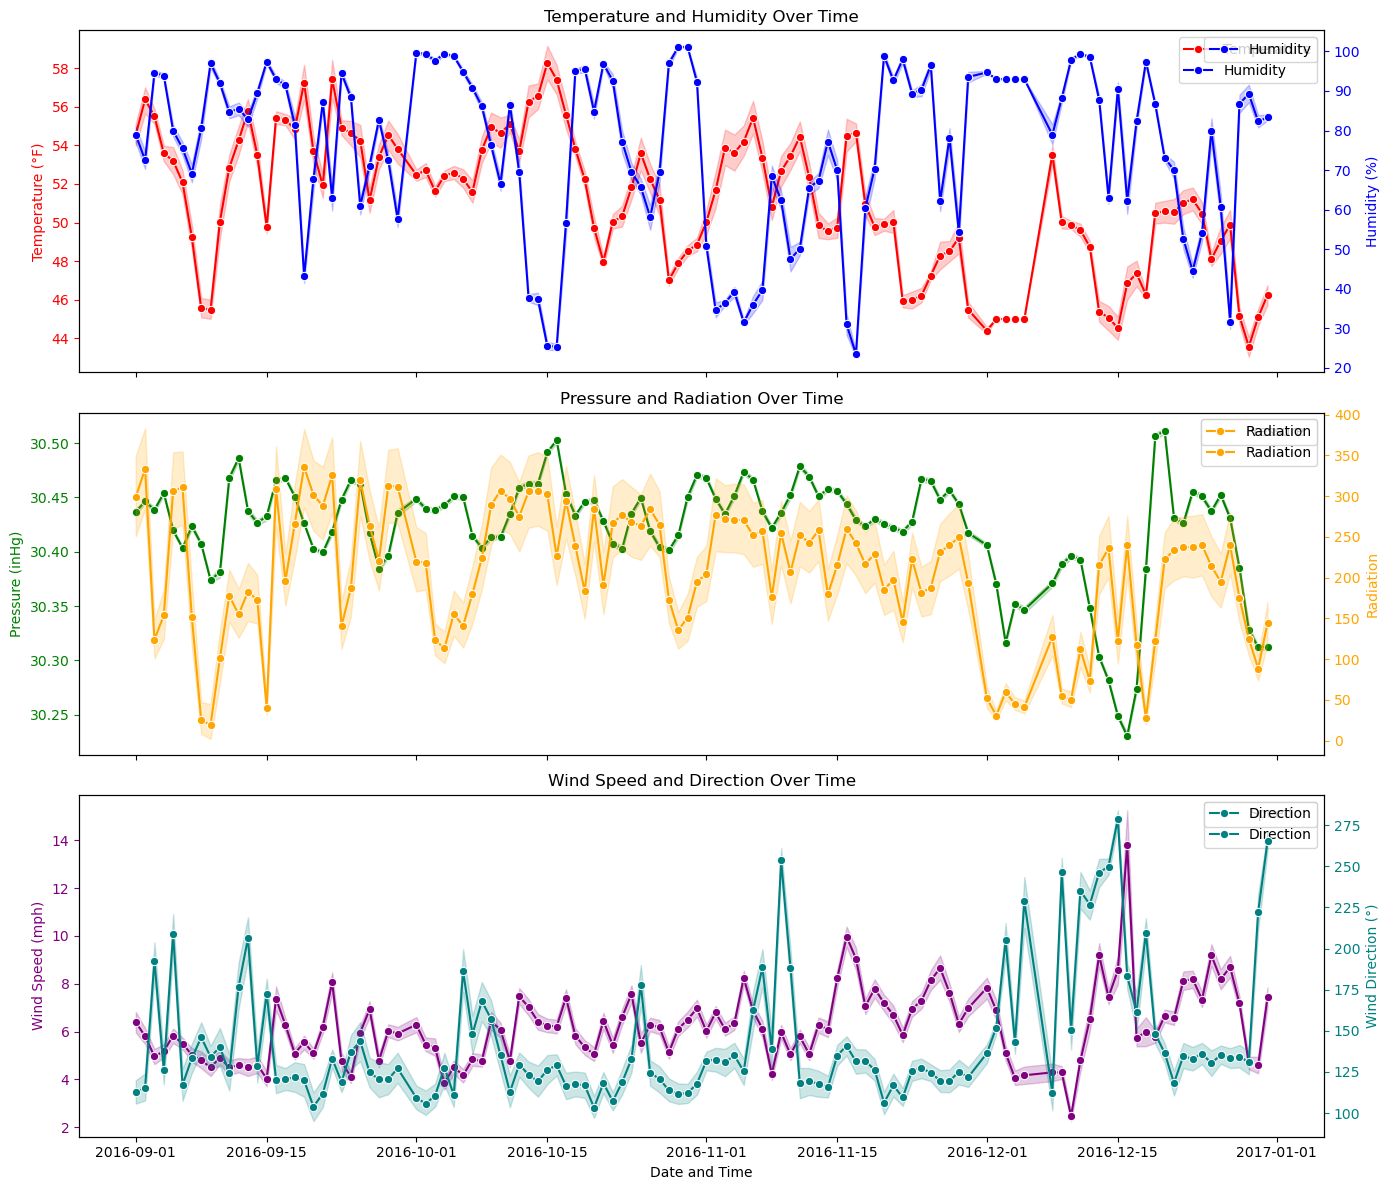

In [4]:

# Alternative visualization: Create a combined plot for related measurements
# Create a figure for related measurements (grouped by type)
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Temperature and Humidity - often related
ax1 = axes[0]
ax1.set_title('Temperature and Humidity Over Time')
ax1_twin = ax1.twinx()  # Create a twin axis for Humidity

# Plot Temperature on left axis
sns.lineplot(x='DateTime', y='Temperature', data=df, marker='o', color='red', label='Temperature', ax=ax1)
ax1.set_ylabel('Temperature (°F)', color='red')
ax1.tick_params(axis='y', colors='red')

# Plot Humidity on right axis
sns.lineplot(x='DateTime', y='Humidity', data=df, marker='o', color='blue', label='Humidity', ax=ax1_twin)
ax1_twin.set_ylabel('Humidity (%)', color='blue')
ax1_twin.tick_params(axis='y', colors='blue')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Pressure and Radiation
ax2 = axes[1]
ax2.set_title('Pressure and Radiation Over Time')
ax2_twin = ax2.twinx()  # Create a twin axis for Radiation

# Plot Pressure on left axis
sns.lineplot(x='DateTime', y='Pressure', data=df, marker='o', color='green', label='Pressure', ax=ax2)
ax2.set_ylabel('Pressure (inHg)', color='green')
ax2.tick_params(axis='y', colors='green')

# Plot Radiation on right axis
sns.lineplot(x='DateTime', y='Radiation', data=df, marker='o', color='orange', label='Radiation', ax=ax2_twin)
ax2_twin.set_ylabel('Radiation', color='orange')
ax2_twin.tick_params(axis='y', colors='orange')

# Add legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Wind Speed and Direction
ax3 = axes[2]
ax3.set_title('Wind Speed and Direction Over Time')
ax3_twin = ax3.twinx()  # Create a twin axis for Direction

# Plot Speed on left axis
sns.lineplot(x='DateTime', y='Speed', data=df, marker='o', color='purple', label='Speed', ax=ax3)
ax3.set_ylabel('Wind Speed (mph)', color='purple')
ax3.tick_params(axis='y', colors='purple')

# Plot Direction on right axis
sns.lineplot(x='DateTime', y='WindDirection(Degrees)', data=df, marker='o', color='teal', 
             label='Direction', ax=ax3_twin)
ax3_twin.set_ylabel('Wind Direction (°)', color='teal')
ax3_twin.tick_params(axis='y', colors='teal')

# Add legend
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Format the x-axis with appropriate date formatting for all subplots
plt.xticks(rotation=45)
ax3.set_xlabel('Date and Time')
plt.tight_layout()

plt.show()




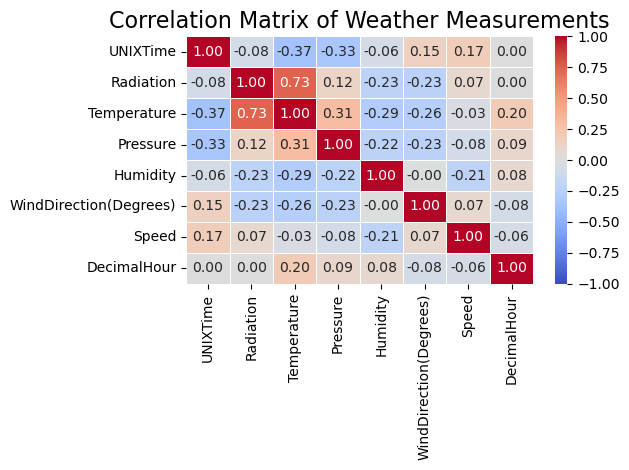

In [5]:
#plot correletions

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute
# Create a decimal hour (hour + minute/60) for better correlation
df['DecimalHour'] = df['Hour'] + df['Minute']/60

# Select only numeric columns for correlation analysis
numeric_columns = ['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 
                   'Humidity', 'WindDirection(Degrees)', 'Speed', 
                   'DecimalHour']
corr_df = df[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = corr_df.corr()

# 1. Create a correlation heatmap
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Weather Measurements', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## LSTM NN

In [48]:
import lstm
import data_prep

target_col = 'Radiation'  # Column to predict


X_train, X_val, X_test, y_train, y_val, y_test, scalers, feature_cols, transform_info = data_prep.prepare_weather_data(
        df,     
        target_col='Radiation',  
        window_size=24,
        feature_selection_mode='basic',  # Start with basic features
        standardize_features=False,  # Try StandardScaler
        use_solar_elevation=True,  # Try the solar elevation feature
        use_piecewise_transform=False,  # Start without piecewise transform
        log_transform=True, #figured out this one is super important
        #min_target_threshold=1.2
)


Adding solar elevation proxy feature
SolarElevation created for 32686 rows, 100.0% of data
Added 'Radiation_is_low' feature (threshold: 1.2000)
Added SolarElevation to features
Log-transformed Radiation -> Radiation_log
Using MinMaxScaler for feature scaling
X_train shape: (19596, 24, 17)
y_train shape: (19596, 1)
X_val shape: (6533, 24, 17)
y_val shape: (6533, 1)
X_test shape: (6533, 24, 17)
y_test shape: (6533, 1)
Features used: ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeMinutesSin', 'TimeMinutesCos', 'Radiation_is_low', 'SolarElevation', 'SunriseMinutes', 'SunsetMinutes', 'DaylightMinutes', 'TimeSinceSunrise', 'TimeUntilSunset', 'DaylightPosition', 'HourOfDay']


In [49]:


input_dim = len(feature_cols)  # Number of features
hidden_dim = 256  # Number of hidden units (increased from 64)
num_layers = 3  # Number of LSTM layers
output_dim = 1  # Dimension of output (predicting a single value)
mse_weight=0.7
mape_weight=0.3
dropout_prob = 0.3
 
# Initialize model
device = torch.device('cpu')
model = lstm.WeatherLSTM(input_dim, hidden_dim, num_layers, output_dim, dropout_prob).to(device)

# Store log transform info in the model
model.log_transform_info = transform_info
    

In [50]:
# Train the model with advanced features
model.fit(
        X_train, y_train, X_val, y_val, 
        epochs=100, 
        batch_size=32, 
        learning_rate=0.001, 
        patience=20,  # Increased patience for better convergence 
        device=device,
        scheduler_type="cosine",  # Try cosine annealing scheduler
        weight_decay=0.001 * 5,  # L2 regularization
        clip_grad_norm=1.5,  # Gradient clipping
        loss_type="value_aware",
        mse_weight=mse_weight,
        mape_weight=mape_weight,
        value_multiplier=0.012 #adjust
    )


X_train shape: (19596, 24, 17), y_train shape: (19596, 1)
X_val shape: (6533, 24, 17), y_val shape: (6533, 1)
Using Value-Aware Combined Loss (MSE weight: 0.7, MAPE weight: 0.3, value multiplier: 0.015)
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 0.0001
- Gradient clipping norm: 1.5
Using CosineAnnealingLR scheduler with T_max=100
Epoch 1/100 - Train loss: 0.160921 - Val loss: 0.064880 - Val RMSE: 0.074363 - Val R²: 0.959926 - Val MAPE: 2.31%
Epoch 2/100 - Train loss: 0.087801 - Val loss: 0.069407 - Val RMSE: 0.076627 - Val R²: 0.957449 - Val MAPE: 2.75%
Epoch 3/100 - Train loss: 0.082830 - Val loss: 0.068919 - Val RMSE: 0.070092 - Val R²: 0.964397 - Val MAPE: 2.24%
Epoch 4/100 - Train loss: 0.082331 - Val loss: 0.069622 - Val RMSE: 0.068265 - Val R²: 0.966229 - Val MAPE: 2.12%
Epoch 5/100 - Train loss: 0.079813 - Val loss: 0.073071 - Val RMSE: 0.080071 - Val R²: 0.953538 - Val MAPE: 2.74%
Epoch 6/100 - Train loss: 0.077319 - Val loss: 0.0720

WeatherLSTM(
  (lstm): LSTM(17, 256, num_layers=3, batch_first=True, dropout=0.3)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

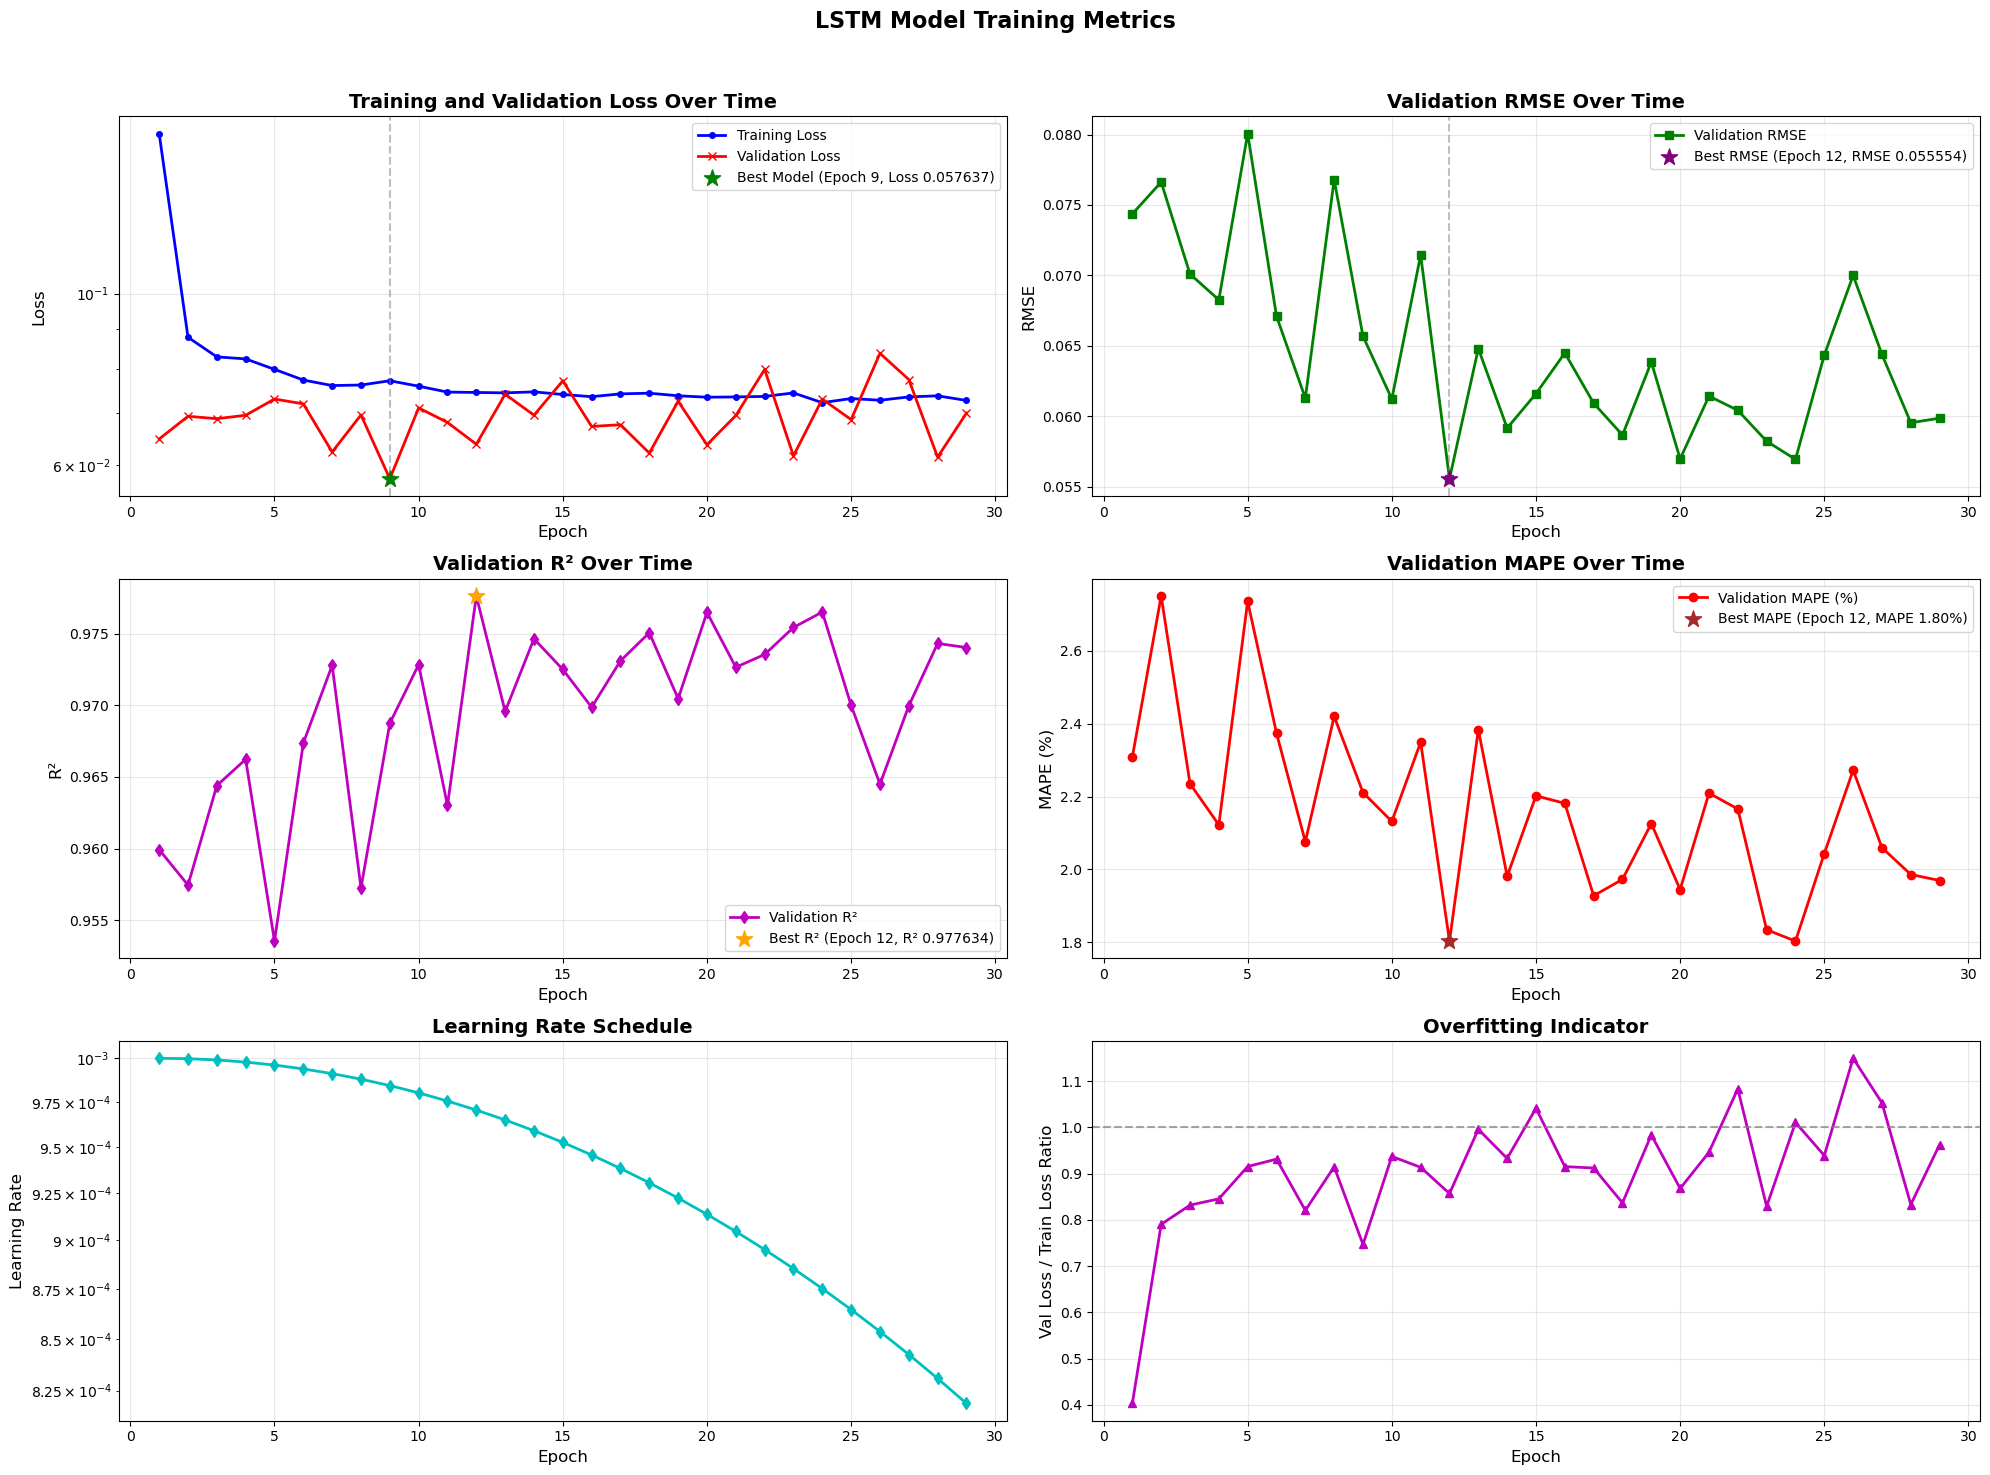

In [51]:
# Visualize training metrics
fig = model.plot_training_history()
plt.show()

In [52]:
# Evaluate on test data
predictions, actuals, metrics = model.evaluate(
        X_test, y_test,
        target_scaler=scalers[transform_info['target_col_transformed']]
    )
    
    
# Calculate RMSE in original scale
rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
#print(f"Test RMSE (original scale): {rmse:.4f}")
    


Scaled Metrics:
Test RMSE: 0.054284
Test R²: 0.978162
Test MAPE (capped at 100%): 17.84%

Original Scale Metrics:
Test RMSE: 0.394871
Test R²: 0.978162
Test MAPE (capped at 100%): 11.41%


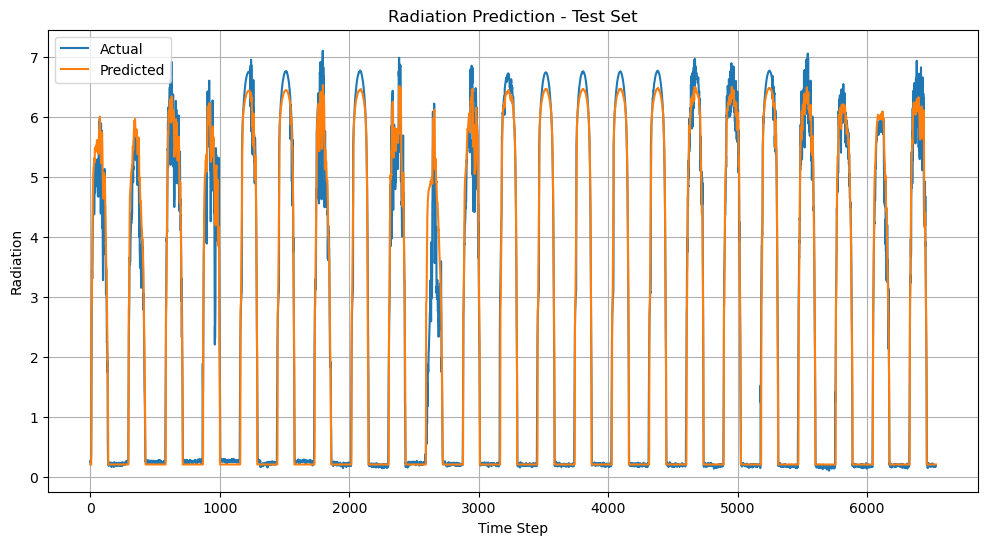

In [53]:
#plot predictions

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

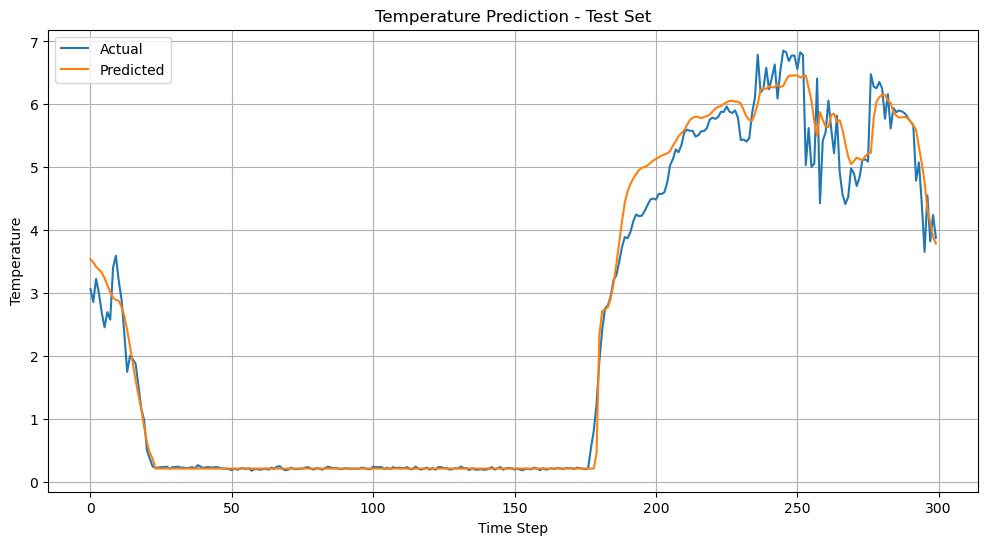

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(actuals[2700:3000], label='Actual')
plt.plot(predictions[2700:3000], label='Predicted')
plt.title('Temperature Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

Resampling data to 1min frequency...
Original data points: 6533, After resampling: 6533
Evaluation Summary:
Number of samples (after resampling): 6533
RMSE: 0.394871
MAE: 0.194052
MAPE: 12.00%
R²: 0.978162
Correlation: 0.989176


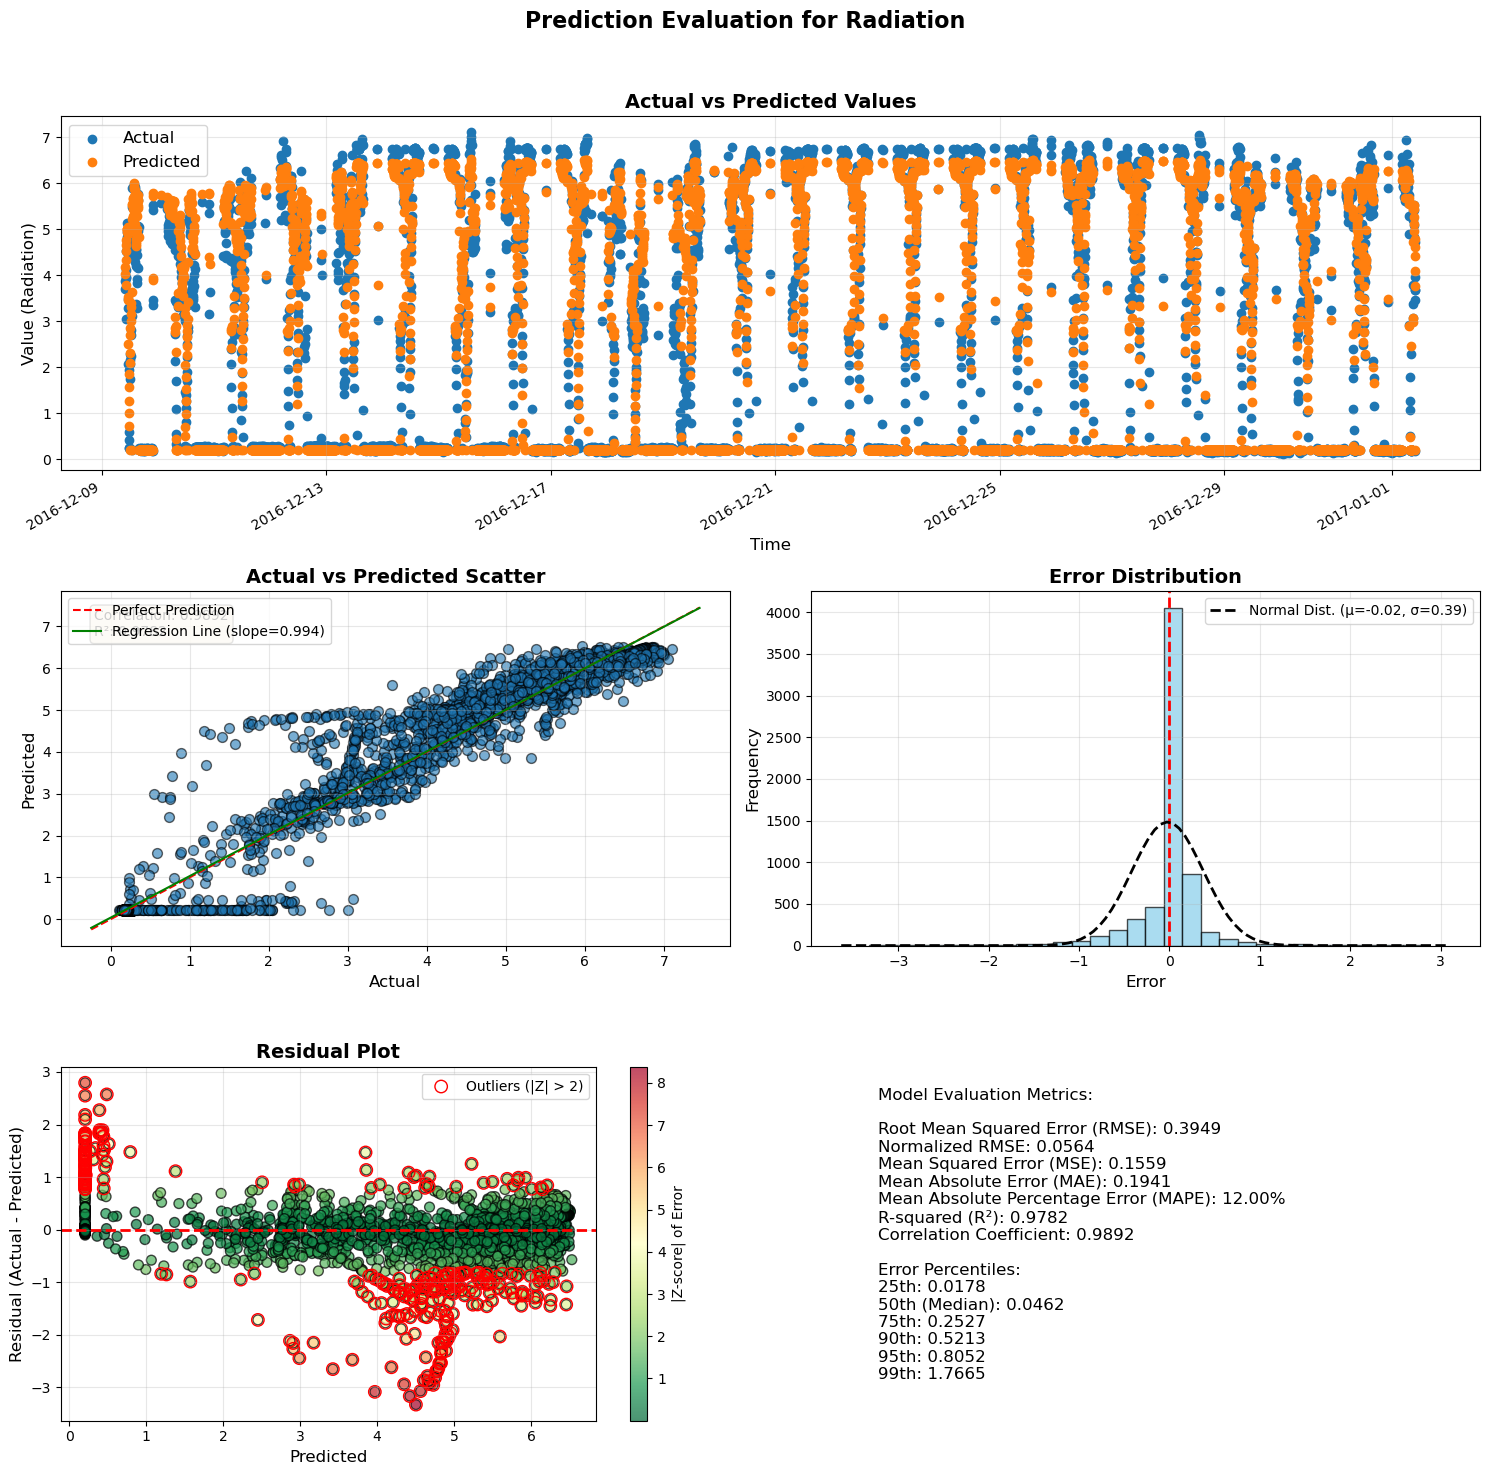

In [56]:
import plot_utils as pu 

# You can create timestamps if your data has a time component
timestamps = df['UNIXTime'].values[-len(predictions):]  # assuming UNIXTime exists in your df

# Make sure scaler is a dictionary with target_col as key
if not isinstance(scalers, dict):
    scalers_dict = {target_col: scalers}
else:
    scalers_dict = scalers

fig_eval = pu.create_evaluation_dashboard(
    predictions=predictions, 
    actuals=actuals, 
    scalers=None,  # !!! there is a bug here
    target_col=target_col,
    timestamps=timestamps
)




## Key Performance Metrics
- **RMSE: 69.7374**
- **Normalized RMSE: 0.0575** (excellent - below 0.1 indicates strong fit)
- **MAE: 33.1875**
- **MAPE: 37.98%**
- **R²: 0.9310**
- **Correlation Coefficient: 0.9656**

## Error Distribution Analysis

The error percentiles reveal a fascinating pattern:

| Percentile | Error Value |
|------------|-------------|
| 25th       | 0.0217      |
| 50th (Median) | 0.0817   |
| 75th       | 46.7872     |
| 90th       | 99.8823     |
| 95th       | 143.1077    |
| 99th       | 293.8402    |

## Insights

1. **Excellent Median Performance**: The median error of only 0.0817 indicates that at least 50% of the predictions are extremely accurate.

2. **Right-Skewed Error Distribution**: The dramatic jump between the 50th percentile (0.0817) and the 75th percentile (46.7872) reveals a highly skewed error distribution.

3. **Targeted Improvement Opportunity**: The large gap between percentiles suggests that the model is highly accurate for most cases but struggles significantly with a specific subset of observations.

4. **Performance Dichotomy**: The excellent normalized RMSE (0.0575) and R² (0.93) alongside the higher MAPE (37.98%) confirm that the model generally performs well but likely struggles with smaller radiation values where small absolute errors translate to large percentage errors.


In [14]:
model.save('weather_lstm_model.pt')

Model saved to weather_lstm_model.pt


# Weather Prediction LSTM Model: Technical Summary

## Model Architecture

**WeatherLSTM Network Structure:**<br>
┌─────────────────────────────────────────────────────┐<br>
│ ➤ LSTM Layer (16→256, layers=2, dropout=0.3)        │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (256→128)                   │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (128→64)                    │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (64→1)                      │<br>
└─────────────────────────────────────────────────────┘

## Core Parameters
- **Input Dimension**: 16 features
- **Hidden Dimension**: 256 (increased from 64)
- **LSTM Layers**: 2
- **Output Dimension**: 1 (predicting a single value)
- **Dropout Probability**: 0.3 (applied at multiple layers)
- **Fully Connected Layers**: 256→128→64→1 with ReLU activations

## Dataset Structure
- **Training Set**: X_train shape: (19596, 24, 16), y_train shape: (19596, 1)
- **Validation Set**: X_val shape: (6533, 24, 16), y_val shape: (6533, 1)
- **Data Format**: 24 timesteps with 16 features per timestep

## Loss Function
The model uses a combined loss function:

$\mathcal{L}_{combined} = 0.7 \times \mathcal{L}_{MSE} + 0.3 \times \mathcal{L}_{MAPE}$

Where:
- $\mathcal{L}_{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_{true} - y_{pred})^2$
- $\mathcal{L}_{MAPE} = \frac{1}{n}\sum_{i=1}^{n}\left|\frac{y_{true} - y_{pred}}{|y_{true}| + \epsilon}\right| \times 100\%$
  - With $\epsilon = 1.0$ to protect against division by zero

## Regularization Techniques
- **Dropout**: Probability of 0.3 at LSTM and after each fully connected layer
- **L2 Regularization**: Weight decay of 0.0001
- **Gradient Clipping**: Norm constrained to 1.0

## Optimization Strategy
- **Learning Rate Scheduler**: CosineAnnealingLR with T_max=100
- **Patience for Early Stopping**: 15 epochs

## Data Transformation
- **Log Transformation**: Applied to Radiation values
  - $Radiation_{log} = \log(Radiation + \epsilon)$
  - Where $\epsilon$ is a small constant (1e-06) to prevent log(0)
- **Feature Engineering**: Added 'Radiation_is_low' binary feature (threshold: 1.2)

## Input Features
16 features including:
- Raw measurements: Radiation, Temperature, Pressure, Humidity, Wind Direction, Speed
- Engineered features: Radiation_is_low, SunriseMinutes, SunsetMinutes, DaylightMinutes
- Temporal features: TimeSinceSunrise, TimeUntilSunset, DaylightPosition
- Cyclical time encoding: TimeMinutesSin, TimeMinutesCos, HourOfDay

This architecture optimally balances model complexity with regularization to prevent overfitting while capturing the temporal patterns in weather data for accurate radiation prediction.